### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account

# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.sales-store"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.sales-store']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productinventory
production-productsubcategory
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.raw_data.sales-store
Lendo os dados do BigQuery...
Tabela sales_store processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: sales_store


In [7]:
# Atribuir o df a uma variável com nome mais simples
sales_store = df_processados['sales_store']

print(f"Colunas: {sales_store.shape[1]}\nLinhas: {sales_store.shape[0]}")

Colunas: 6
Linhas: 7010


In [8]:
# Identificar duplicadas com base em 'businessentityid'
duplicadas = sales_store[
    sales_store.duplicated(subset=['businessentityid'], keep=False)
]

# Verificar se existem duplicadas
if not duplicadas.empty:
    # Ordenar duplicadas por 'businessentityid' e 'modifieddate'
    duplicadas_ordenadas = duplicadas.sort_values(by=['businessentityid', 'modifieddate'])

    # Exibir duplicadas ordenadas
    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
      businessentityid                   name  salespersonid                                                                                                                                                                                                                                                                                                                                                                                                                          demographics                               rowguid                     modifieddate
1200               292   Next-Door Bike Store            279      <StoreSurvey xmlns="http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey"><AnnualSales>800000</AnnualSales><AnnualRevenue>80000</AnnualRevenue><BankName>United Security</BankName><BusinessType>BM</BusinessType><YearOpened>1996</YearOpened><Specialty>Mountain</Specialty><SquareFeet>21000</SquareFeet><Brands>2</Brands><Internet>ISDN</In

In [9]:
# Remover duplicadas mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
# Importante, pois se houver erro na ingestão (duplicação), mantém os dados integros.

sales_store = sales_store.drop_duplicates(subset=['businessentityid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(sales_store)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = sales_store.copy()


#doc: bkp = backup (cópia)

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 701


In [10]:
# Ordenar e exibir o df por 'businessentityid'
sales_store = sales_store.sort_values(by=['businessentityid'])

print(sales_store)

      businessentityid                            name  salespersonid                                                                                                                                                                                                                                                                                                                                                                                                                                demographics                               rowguid                     modifieddate
4709               292            Next-Door Bike Store            279            <StoreSurvey xmlns="http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey"><AnnualSales>800000</AnnualSales><AnnualRevenue>80000</AnnualRevenue><BankName>United Security</BankName><BusinessType>BM</BusinessType><YearOpened>1996</YearOpened><Specialty>Mountain</Specialty><SquareFeet>21000</SquareFeet><Brands>2</Brands><Internet>

In [11]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in sales_store.columns:   
    missing_rows = sales_store[sales_store[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'businessentityid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'businessentityid'.

Coluna 'name': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'name'.

Coluna 'salespersonid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salespersonid'.

Coluna 'demographics': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'demographics'.

Coluna 'rowguid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'rowguid'.

Coluna 'modifieddate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'modifieddate'.



In [12]:
#deletar coluna desnecessárias
sales_store = sales_store.drop(columns=['demographics'])

print("Colunas restantes após remoção:")
print(sales_store.columns)

Colunas restantes após remoção:
Index(['businessentityid', 'name', 'salespersonid', 'rowguid', 'modifieddate'], dtype='object')


In [13]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = sales_store.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

#doc: currentflag possue somente 1 valor, o que indica que pode ser somente valores True ou False.

Valores únicos incluindo NaN:
businessentityid    701
name                699
salespersonid        13
rowguid             701
modifieddate          1
dtype: int64


In [14]:
#verificar informações do df
sales_store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701 entries, 4709 to 3509
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   businessentityid  701 non-null    Int64              
 1   name              701 non-null    object             
 2   salespersonid     701 non-null    Int64              
 3   rowguid           701 non-null    object             
 4   modifieddate      701 non-null    datetime64[us, UTC]
dtypes: Int64(2), datetime64[us, UTC](1), object(2)
memory usage: 34.2+ KB


In [15]:
#avaliando as variáveis qualitativas*

coluna_quantitativa = ["name"]
for col in coluna_quantitativa:
    counts = sales_store[col].value_counts().nlargest(10)
    percentages = (counts / sales_store.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(summary)    


#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, name, por exemplo

                                     qtde.      %
name                                             
Sports Products Store                    2  0.29%
Friendly Bike Shop                       2  0.29%
Next-Door Bike Store                     1  0.14%
Road Way Sales and Rental                1  0.14%
Beneficial Exercises and Activities      1  0.14%
Fad Outlet                               1  0.14%
Commerce Bicycle Specialists             1  0.14%
Township Inn                             1  0.14%
Acceptable Sales & Service               1  0.14%
Brown Bicycle Company                    1  0.14%


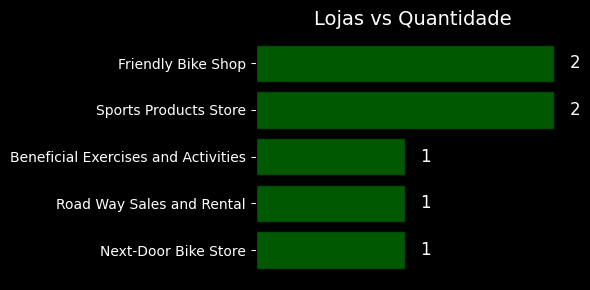

In [16]:
# Dados ajustados com as 5 primeiras lojas, em ordem decrescente
top_5_stores = sales_store['name'].value_counts().nlargest(5).sort_values(ascending=True)

names = top_5_stores.index
values = top_5_stores.values

# Criar o gráfico de barras horizontais
plt.figure(figsize=(6, 3))
plt.barh(names, values, color='green', edgecolor='black', alpha=0.7)

# Adicionar título
plt.title('Lojas vs Quantidade', fontsize=14, color='white')

# Ajustar cor do plano de fundo e rótulos
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.tick_params(axis='x', bottom=False, labelbottom=False)  # Remove valores do eixo X
plt.tick_params(axis='y', colors='white')

# Remover títulos dos eixos
plt.xlabel("")
plt.ylabel("")

# Adicionar valores ao lado das barras
for index, value in enumerate(values):
    plt.text(value + 0.1, index, f'{value}', va='center', fontsize=12, color='white')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


In [17]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['sales_store'] = sales_store

In [18]:
sales_store.head()

,businessentityid,name,salespersonid,rowguid,modifieddate
4709,292,Next-Door Bike Store,279,a22517e3-848d-4ebe-b9d9-7437f3432304,2014-09-12 11:15:07.497000+00:00
3919,294,Professional Sales and Service,276,b50ca50b-c601-4a13-b07e-2c63862d71b4,2014-09-12 11:15:07.497000+00:00
4159,296,Riders Company,277,337c3688-1339-4e1a-a08a-b54b23566e49,2014-09-12 11:15:07.497000+00:00
3574,298,The Bike Mechanics,275,7894f278-f0c8-4d16-bd75-213fdbf13023,2014-09-12 11:15:07.497000+00:00
6259,300,Nationwide Supply,286,c3fc9705-a8c4-4f3a-9550-eb2fa4b7b64d,2014-09-12 11:15:07.497000+00:00


In [19]:
# Padronizar colunas com valores textuais
sales_store['name'] = sales_store['name'].str.strip().str.upper()
sales_store['rowguid'] = sales_store['rowguid'].str.strip().str.upper()

print(sales_store.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

      businessentityid                            name  salespersonid                               rowguid                     modifieddate
4709               292            NEXT-DOOR BIKE STORE            279  A22517E3-848D-4EBE-B9D9-7437F3432304 2014-09-12 11:15:07.497000+00:00
3919               294  PROFESSIONAL SALES AND SERVICE            276  B50CA50B-C601-4A13-B07E-2C63862D71B4 2014-09-12 11:15:07.497000+00:00
4159               296                  RIDERS COMPANY            277  337C3688-1339-4E1A-A08A-B54B23566E49 2014-09-12 11:15:07.497000+00:00
3574               298              THE BIKE MECHANICS            275  7894F278-F0C8-4D16-BD75-213FDBF13023 2014-09-12 11:15:07.497000+00:00
6259               300               NATIONWIDE SUPPLY            286  C3FC9705-A8C4-4F3A-9550-EB2FA4B7B64D 2014-09-12 11:15:07.497000+00:00


In [20]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela sales_store exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.sales_store.
